<a href="https://colab.research.google.com/github/runnin123/Jeju_Bigdata/blob/master/Jeju_bigdata_0708.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'jeju-bigquery-282708'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train` 
  WHERE RAND() < 1000 / (SELECT COUNT(*) FROM `jeju-bigquery-282708.jeju_bigdata.201901_202003_train`)
  ''').to_dataframe()

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 03 Chapter에서 추가
# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 06 Chapter 추가
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
seaborn : 0.10.1
matplotlib : 3.2.2
Python 3.6.9


In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    202003
1    201903
2    201905
3    201906
4    202003
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,경기,시흥시,한식 음식점업,강원,영월군,20s,1,1,5,360600,12,2020,3
1,경북,영주시,기타음식료품위주종합소매업,강원,강릉시,50s,1,4,3,116200,5,2019,3
2,경기,안성시,기타음식료품위주종합소매업,강원,춘천시,60s,1,5,3,492200,4,2019,5
3,강원,고성군,기타 외국식 음식점업,강원,고성군,60s,1,5,27,866000,29,2019,6
4,강원,인제군,슈퍼마켓,강원,양구군,60s,1,5,3,150950,3,2020,3


In [ ]:
# 데이터 정제
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

In [ ]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=126, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((709, 8), (709,), (304, 8), (304,))


 mu = 1680247.74 and sigma = 6548093.42



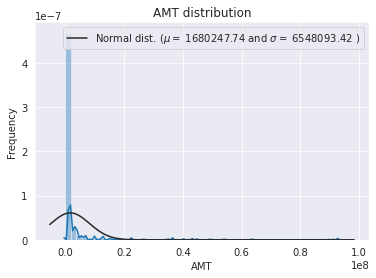

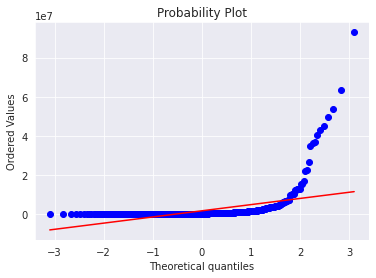

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()


 mu = 12.57 and sigma = 1.67



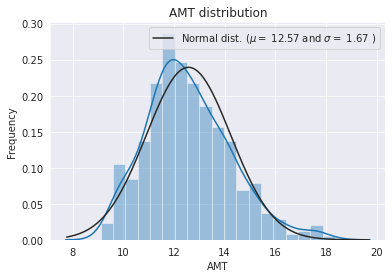

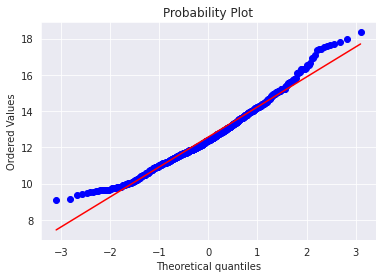

In [ ]:
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

In [ ]:
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

0.90


In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.15, random_state = 1)

xgb_reg = XGBRegressor(verbosity=0) 
print(xgb_reg)

xgb_reg.fit(X_train, y_train)
score = xgb_reg.score(X_train, y_train)  
print("Training score: ", score)

y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
print(lightgbm.__version__)

2.2.3


In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_training, X_testing, y_training, y_testing = train_test_split(x, y, test_size=0.15, random_state = 1)

lgb_reg = LGBMRegressor(verbosity=0) 
print(lgb_reg)

lgb_reg.fit(X_training, y_training)
score = lgb_reg.score(X_training, y_training)  
print("Training score: ", score)

y_pred = lgb_reg.predict(X_testing)
mse = mean_squared_error(y_testing, y_pred)
print("MSE: %.2f" % mse)

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_training , X_testing , y_training , y_testing = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습. 
knn_clf.fit(X_training, y_training)
rf_clf.fit(X_training , y_training)
dt_clf.fit(X_training , y_training)
ada_clf.fit(X_training, y_training)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_testing)
rf_pred = rf_clf.predict(X_testing)
dt_pred = dt_clf.predict(X_testing)
ada_pred = ada_clf.predict(X_testing)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_testing, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_testing, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_testing, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_testing, ada_pred)))

In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

lr_final.fit(pred, y_testing)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_testing , final)))

In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

In [ ]:
# 교차검증 수행
def get_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train, y_train)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test, eval_pred)
  
  return cv_model.best_estimator_

In [ ]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

[03:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[03:20:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(X_test)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test, final)

In [ ]:
from itertools import product

# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [ ]:
# 예측 데이터 세트
xgb_pred = xgb_reg.predict(temp)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(temp)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(temp)
lgb_pred = np.expm1(lgb_pred)

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20

temp['AMT'] = np.round(final, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

In [ ]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

temp.head()

In [ ]:
# Submission 파일 작업 및 내보내기
submission = client.query('''
  SELECT 
    * 
  FROM `jeju-bigquery-282708.jeju_bigdata.submission` 
  ''').to_dataframe()

In [ ]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)

submission.head()

In [ ]:
submission.to_csv('/content/drive/My Drive/Colab Notebooks/jeju/submission.csv', encoding='utf-8-sig', index=False)